# STEAM #

## Goals ##
The ultimate goal of this project is to understand what factors affect the popularity or sales of a video game. But your boss asked you to take advantage of this opportunity to analyze the video game market globally.

To carry out this project, you will have to adopt different levels of analysis. Your boss gave you a list of examples of questions that would be interesting:

In [0]:
FILEPATH = 's3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json'
steam_game_dtf = spark.read.format('json')\
             .option('header', 'true')\
             .option('inferSchema', 'true')\
             .load(FILEPATH)
print(type(steam_game_dtf))

<class 'pyspark.sql.dataframe.DataFrame'>


In [0]:
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import udf


### Define constants, utility methods ###

In [0]:
# Constants
DECIMAL_FORMAT_2 = "%.2f"
def format_2_decimals(number) -> str:
    return (DECIMAL_FORMAT_2 % number)

def format_2_decimals_column(column) -> str:
    return F.format_number(column,2)

def is_null(column) -> bool:
    return (F.isnan(column) | F.col(column).isNull())

def str_length_function(stringColumn) :
    return F.length(F.trim(stringColumn))

def is_empty_string(stringColumn) -> bool:
    return (str_length_function(stringColumn)==0)
 
str_length_udf = udf(str_length_function, IntegerType())

### Display dataframe's schema ###

In [0]:
steam_game_dtf.printSchema()

In [0]:
#steam_game_dtf.show(2, truncate=False)
steam_game_dtf.select("data.*").show(1, vertical=True)

#row = steam_game_dtf.first().asDict()
#for col, val in row.items():
#   print(f"{col}: {val}")

-RECORD 0---------------------------------
 appid             | 10                   
 categories        | [Multi-player, Va... 
 ccu               | 13990                
 developer         | Valve                
 discount          | 0                    
 genre             | Action               
 header_image      | https://cdn.akama... 
 initialprice      | 999                  
 languages         | English, French, ... 
 name              | Counter-Strike       
 negative          | 5199                 
 owners            | 10,000,000 .. 20,... 
 platforms         | {true, true, true}   
 positive          | 201215               
 price             | 999                  
 publisher         | Valve                
 release_date      | 2000/11/1            
 required_age      | 0                    
 short_description | Play the world's ... 
 tags              | {266, 1191, null,... 
 type              | game                 
 website           |                      
only showin

Nested schema. We can notice that some fields store multiple values in different forms, 
some are structured as array (for example categories), others are defined as single string with separator between values (genre). 
Root is divided in two nodes : id (unique id) and data node 

Number of rows

In [0]:
row_count = steam_game_dtf.count()
print('steam_game_dtf row count : ', row_count)

steam_game_dtf row count :  55691


### Explode data Struct (not working since Array is excepted as top-level node) ###

In [0]:

#steam_game_data_exploded_dtf = steam_game_dtf.withColumn('data', F.explode('data') )
#steam_game_data_exploded_dtf.show(2)

In [0]:
steam_game_dtf.select("data.*").columns

Out[7]: ['appid',
 'categories',
 'ccu',
 'developer',
 'discount',
 'genre',
 'header_image',
 'initialprice',
 'languages',
 'name',
 'negative',
 'owners',
 'platforms',
 'positive',
 'price',
 'publisher',
 'release_date',
 'required_age',
 'short_description',
 'tags',
 'type',
 'website']

### Create steam_game_dtf_level0 data frame with single* columns. ###
#### * columns that are not Array nor Struct ####
#### Remark, some fields contains multiple values as a comma separated Strings (like languages column,...) ####

In [0]:
data_simple_fields = (colname for colname in steam_game_dtf.select("data.*").columns if colname not in ('categories','platforms', 'tags'))
steam_game_dtf_level0 = steam_game_dtf.select(
    'id',
    *(F.col(f"data.{s}").alias(s) for s in data_simple_fields)
).alias('data').select('data.*') 


##### Compute null values count for each column (for steam_game_dtf_level0) #####

In [0]:
steam_game_dtf_level0.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in steam_game_dtf_level0.columns]
   ).show(vertical=True)

-RECORD 0----------------
 id                | 0   
 appid             | 0   
 ccu               | 0   
 developer         | 0   
 discount          | 0   
 genre             | 0   
 header_image      | 0   
 initialprice      | 0   
 languages         | 0   
 name              | 0   
 negative          | 0   
 owners            | 0   
 positive          | 0   
 price             | 0   
 publisher         | 0   
 release_date      | 0   
 required_age      | 0   
 short_description | 0   
 type              | 0   
 website           | 0   



##### Compute empty string count for each string column #####

In [0]:
steam_game_dtf_level0.dtypes

Out[10]: [('id', 'string'),
 ('appid', 'bigint'),
 ('ccu', 'bigint'),
 ('developer', 'string'),
 ('discount', 'string'),
 ('genre', 'string'),
 ('header_image', 'string'),
 ('initialprice', 'string'),
 ('languages', 'string'),
 ('name', 'string'),
 ('negative', 'bigint'),
 ('owners', 'string'),
 ('positive', 'bigint'),
 ('price', 'string'),
 ('publisher', 'string'),
 ('release_date', 'string'),
 ('required_age', 'string'),
 ('short_description', 'string'),
 ('type', 'string'),
 ('website', 'string')]

In [0]:
steam_game_dtf_level0.select([F.count(F.when(is_empty_string(F.col(string_col)), string_col)).alias(string_col)\
            for string_col in (dtype[0] for dtype in steam_game_dtf_level0.dtypes if dtype[1]=='string') ]).show(vertical=True)

-RECORD 0------------------
 id                | 0     
 developer         | 127   
 discount          | 0     
 genre             | 161   
 header_image      | 0     
 initialprice      | 0     
 languages         | 11    
 name              | 0     
 owners            | 0     
 price             | 0     
 publisher         | 134   
 release_date      | 99    
 required_age      | 0     
 short_description | 37    
 type              | 0     
 website           | 25217 



### I choose to remove rows with any of the fields used downstream with empty strings ###

In [0]:
steam_game_dtf_level0 = steam_game_dtf_level0.filter(~(is_empty_string('genre') | is_empty_string('publisher') | is_empty_string('languages') | is_empty_string('release_date')))

In [0]:
row_count = steam_game_dtf_level0.count()
print('steam_game_dtf_level0 row count after removing empty strings: ', row_count)

steam_game_dtf_level0 row count after removing empty strings:  55310


#### Change data types of columns holding prices ####

In [0]:
steam_game_dtf_level0 = steam_game_dtf_level0.withColumn('price', F.col('price').cast(IntegerType()))\
    .withColumn('initialprice', F.col('initialprice').cast(IntegerType()))\
    .withColumn('discount', F.col('discount').cast(IntegerType()))
# Display row sample
steam_game_dtf_level0.select('*').limit(2).show(vertical=True)

-RECORD 0---------------------------------
 id                | 10                   
 appid             | 10                   
 ccu               | 13990                
 developer         | Valve                
 discount          | 0                    
 genre             | Action               
 header_image      | https://cdn.akama... 
 initialprice      | 999                  
 languages         | English, French, ... 
 name              | Counter-Strike       
 negative          | 5199                 
 owners            | 10,000,000 .. 20,... 
 positive          | 201215               
 price             | 999                  
 publisher         | Valve                
 release_date      | 2000/11/1            
 required_age      | 0                    
 short_description | Play the world's ... 
 type              | game                 
 website           |                      
-RECORD 1---------------------------------
 id                | 1000000              
 appid     

#### Compute owners_min, owners_max columns (for later use) ####

In [0]:
# Test
steam_game_dtf_level0.withColumn('test_owners_length', F.size(F.expr("transform(split(owners,r'\.\.'),x -> trim(x))")))\
    .groupBy('test_owners_length').agg(F.count('id')).show()

# 

+------------------+---------+
|test_owners_length|count(id)|
+------------------+---------+
|                 2|    55310|
+------------------+---------+



In [0]:
steam_game_dtf_level0 = steam_game_dtf_level0.withColumn('owners_min_max', F.expr("transform(split(owners,r'\.\.'),x -> trim(x))"))\
    .withColumn('owners_min', F.regexp_replace(F.col('owners_min_max')[0],",","").cast(IntegerType()))\
    .withColumn('owners_max', F.regexp_replace(F.col('owners_min_max')[1],",","").cast(IntegerType()))\
    .withColumn('avg_owners', ((F.col('owners_max')+F.col('owners_min'))/2).cast(IntegerType()))\
        .drop(F.col('owners'), F.col('owners_min_max'))
    # Check
steam_game_dtf_level0.select('owners_min', 'owners_max','avg_owners').limit(10).show()

# or use steam_game_dtf_level0 = steam_game_dtf_level0.withColumn( 'owners_min_max',F.transform(F.split('owners', r'\.\.'), lambda x: F.trim(x)))

+----------+----------+----------+
|owners_min|owners_max|avg_owners|
+----------+----------+----------+
|  10000000|  20000000|  15000000|
|         0|     20000|     10000|
|    200000|    500000|    350000|
|    100000|    200000|    150000|
|         0|     20000|     10000|
|    100000|    200000|    150000|
|         0|     20000|     10000|
|     20000|     50000|     35000|
|         0|     20000|     10000|
|         0|     20000|     10000|
+----------+----------+----------+



#### Compute average income (for later use) ####

For each row/game : average_income = (price-discount) * (mean(owners_min,owners_max)). Will be used later in genre analysis. 

In [0]:
steam_game_dtf_level0 = steam_game_dtf_level0.withColumn('average_income', ((F.col('price')-F.col('discount'))*(F.col('owners_max')-F.col('owners_min'))/2))
steam_game_dtf_level0.select('name', 'price', 'discount', 'owners_min', 'owners_max', 'average_income').limit(2).show()


+--------------+-----+--------+----------+----------+--------------+
|          name|price|discount|owners_min|owners_max|average_income|
+--------------+-----+--------+----------+----------+--------------+
|Counter-Strike|  999|       0|  10000000|  20000000|  7.00032704E8|
|     ASCENXION|  999|       0|         0|     20000|     9990000.0|
+--------------+-----+--------+----------+----------+--------------+



## Analysis at the "macro" level ##

### What are the best-selling games ? ###

In [0]:
steam_game_dtf_level0.select('id','name', 'avg_owners', 'genre').orderBy(F.desc('avg_owners')).limit(10).show()

+-------+--------------------+----------+--------------------+
|     id|                name|avg_owners|               genre|
+-------+--------------------+----------+--------------------+
|    570|              Dota 2| 350000000|Action, Free to P...|
|1063730|           New World|  75000000|Action, Adventure...|
|    440|     Team Fortress 2|  75000000|Action, Free to Play|
| 578080| PUBG: BATTLEGROUNDS|  75000000|Action, Adventure...|
|    730|Counter-Strike: G...|  75000000|Action, Free to Play|
| 105600|            Terraria|  35000000|Action, Adventure...|
|1085660|           Destiny 2|  35000000|Action, Adventure...|
|1097150|Fall Guys: Ultima...|  35000000|Action, Casual, I...|
|1172470|        Apex Legends|  35000000|Action, Adventure...|
| 236390|         War Thunder|  35000000|Action, Free to P...|
+-------+--------------------+----------+--------------------+



### Which publisher has released the most games on Steam ?

##### Top 10 publisher in term of number of games (Ubisoft belongs to top 10) #####

In [0]:
df_top_publishers = steam_game_dtf_level0.groupBy(F.col('publisher')).agg(F.count('name').alias('nb_games'))\
.orderBy(F.desc('nb_games')).limit(10)
display(df_top_publishers)

publisher,nb_games
Big Fish Games,421
8floor,202
Strategy First,151
SEGA,142
Square Enix,139
Choice of Games,139
Sekai Project,132
HH-Games,132
Ubisoft,126
Laush Studio,126


Databricks visualization. Run in Databricks to view.

### What are the best rated games?

##### We suppose ratings are given by "positive" and "negative" columns where "positive" gives the number of positive notifications #####
##### We define positive_rate column as positive/(negative+positive) when positive + negative  > 0 #####

In [0]:

steam_game_dtf_level0 = steam_game_dtf_level0.withColumn('positive_rate', F.when((F.col('negative') + F.col('positive')) > 0\
                                             , F.col('positive')/(F.col('negative') + F.col('positive'))).otherwise(F.lit(0.0)))

# top_10_best_rated_games = 
steam_game_dtf_level0.select(F.col('name'), F.col('avg_owners'),F.col('positive_rate'), F.col('positive'), F.col('negative'), F.col('genre'))\
               .orderBy(F.desc('positive_rate')).limit(10).show()


+--------------------+----------+-------------+--------+--------+--------------------+
|                name|avg_owners|positive_rate|positive|negative|               genre|
+--------------------+----------+-------------+--------+--------+--------------------+
|         Next Stop 3|     10000|          1.0|      17|       0|Casual, Simulatio...|
|Kooring VR Wonder...|     10000|          1.0|      12|       0|Action, Adventure...|
|            Diamonds|     10000|          1.0|       4|       0|       Action, Indie|
|               GUIDE|     10000|          1.0|       2|       0|               Indie|
|Fist Of Heaven & ...|     10000|          1.0|       7|       0|Action, Adventure...|
|            Grab Lab|     10000|          1.0|       9|       0|Action, Casual, I...|
|Zero spring episo...|     10000|          1.0|       1|       0|Adventure, Indie,...|
|      Twisting Mower|     10000|          1.0|       1|       0|Casual, Indie, Ra...|
|   The Demon Crystal|     10000|          

#### We can see above games with 100% positive_rate.####

#### Let's see avg_owners distribution and display best rates games for the most represented class (if any) ####

In [0]:
bins, counts = steam_game_dtf_level0.select('avg_owners').rdd.flatMap(lambda x: x).histogram(10)
avg_owners_histo_data = list(zip(bins,counts))
avg_owners_histo_dtf = spark.createDataFrame(avg_owners_histo_data, ["bin", "count"])
display(avg_owners_histo_dtf)

bin,count
10000,55305
35009000,0
70008000,4
105007000,0
140006000,0
175005000,0
210004000,0
245003000,0
280002000,0
315001000,1


#### Define other bins decomposition as most of the games belong to [1, 10000] ####

In [0]:
display(steam_game_dtf_level0.filter(F.col('avg_owners') < 10000 ).select('name','avg_owners').orderBy(F.asc('avg_owners')).limit(10))

name,avg_owners


#### As we can see above, the most important class in terms of avg_owners is [0,10000]. In addition all these games have 10000 avg_owners. So let focus on this class and see what are the 10 best rated games #### 

In [0]:
best_rated_games_dtf = steam_game_dtf_level0.filter(F.col('avg_owners') == 10000 ).select(F.col('name'), F.col('avg_owners')\
                    ,F.col('positive_rate'), F.col('positive'), F.col('negative'), F.col('genre'))\
               .orderBy( F.desc('positive_rate'),F.desc('positive')).limit(10)
display(best_rated_games_dtf)

name,avg_owners,positive_rate,positive,negative,genre
The Void Rains Upon Her Heart,10000,1.0,496,0,"Action, Indie, Early Access"
祈風 Inorikaze,10000,1.0,327,0,"Adventure, Casual, Indie"
秘封旅行 ~ Secret Sealing Travel,10000,1.0,218,0,"Casual, Indie, RPG, Simulation, Early Access"
Elasto Mania Remastered,10000,1.0,190,0,"Casual, Indie, Racing, Simulation, Sports"
Freshly Frosted,10000,1.0,157,0,"Casual, Indie, Simulation, Strategy"
HAYAI,10000,1.0,148,0,Action
FIND ALL 2: Middle Ages,10000,1.0,132,0,"Casual, Indie"
Lucy Dreaming,10000,1.0,118,0,Adventure
未来战士,10000,1.0,116,0,"Action, Adventure, Casual"
Distant Memoraĵo,10000,1.0,114,0,"Adventure, Indie"


Databricks visualization. Run in Databricks to view.

In [0]:
steam_game_view = steam_game_dtf_level0.createOrReplaceTempView('steam_games_view')

dct = dict()
dct["positive_count"] =spark.sql('SELECT * FROM steam_games_view WHERE positive > 0').count()
dct["negative_count"] =spark.sql('SELECT * FROM steam_games_view WHERE negative > 0').count()
dct

Out[24]: {'positive_count': 53468, 'negative_count': 46544}

### Are there years with more releases? Were there more or fewer game releases during the Covid, for example? ###

As we have seen before, dataset contains rows with empty release_date values. Compute release_date's length distribution. 

In addition explore the different date formats to be parsed to date

In [0]:

 release_date_str_length_col_name = 'release_date_str_length'
 steam_game_dtf_level0.filter(F.col('release_date').isNotNull())\
    .withColumn(release_date_str_length_col_name, str_length_function(F.col('release_date')))\
    .groupBy(release_date_str_length_col_name).agg(F.count('id').alias('row_count')).orderBy(F.asc('row_count')).show()


+-----------------------+---------+
|release_date_str_length|row_count|
+-----------------------+---------+
|                      7|      122|
|                      9|    15651|
|                     10|    39537|
+-----------------------+---------+



#### Display release_date samples by length to see date formats ####

In [0]:
steam_game_dtf_level0.filter(F.col('release_date').isNotNull())\
    .withColumn(release_date_str_length_col_name, str_length_function(F.col('release_date')))\
        .filter(F.col('release_date_str_length')>0)\
    .groupBy(release_date_str_length_col_name).agg((F.slice(F.collect_list('release_date'),1,2)).alias('release_date_list_sample'))\
        .show()

+-----------------------+------------------------+
|release_date_str_length|release_date_list_sample|
+-----------------------+------------------------+
|                      9|    [2000/11/1, 2019/...|
|                      7|      [2019/01, 2019/04]|
|                     10|    [2021/05/14, 2020...|
+-----------------------+------------------------+



#### Filter out rows with empty release dates and create date-type column and year column ####

In [0]:
from datetime import datetime


to_date_udf =  udf (lambda x: datetime.strptime(x, '%Y/%m/%d'), DateType())
to_date_udf_ym =  udf (lambda x: datetime.strptime(F.concat(x,F.lit('/01')), '%Y/%m/%d'), DateType())

def is_valid_date(date_str):
    try:
        #to_date_udf(date_str)
        datetime.strptime(date_str, '%Y/%m/%d')
        return True
    except ValueError:
        return False
    
valid_date_udf = udf(is_valid_date, BooleanType())
# we discard upstream rows with empty release_date (str) - no need to filter
# steam_game_dtf_level0.filter(F.col('release_date').isNotNull() & (str_length_function(F.col('release_date'))>0))\

print('steam_game_dtf_level0 row count before date processing : ', steam_game_dtf_level0.count())

steam_game_dtf_level0_dates = steam_game_dtf_level0\
    .withColumn('release_date_copy', F.regexp_replace(F.col("release_date"), "-", "/"))\
    .withColumn('valid_date', valid_date_udf(F.col('release_date_copy')))\
    .withColumn("release_date_str", F.when(F.col('valid_date'), F.col('release_date_copy'))\
                .otherwise(F.concat(F.col('release_date_copy'),F.lit('/01')))\
                )\
    .withColumn("release_date_temp", to_date_udf(F.col('release_date_str')))\
    .withColumn('release_date_year', F.year(F.col('release_date_temp')))\
    .withColumn('valid_date', valid_date_udf(F.col('release_date_str')))\
    .drop(F.col('release_date'), F.col('release_date_copy'), F.col('release_date_str'))\
    .withColumnRenamed('release_date_temp', 'release_date')

print('steam_game_dtf_level0 row count with valid release_date : ', steam_game_dtf_level0_dates.filter(F.col('valid_date')).count())

games_count = steam_game_dtf_level0.count()


steam_game_dtf_level0 row count before date processing :  55310
steam_game_dtf_level0 row count with valid release_date :  55310


In [0]:
games_count = steam_game_dtf_level0.count()

#### All release_date valid, so we keep working on steam_game_dtf_level0 ####

In [0]:
steam_game_dtf_level0 = steam_game_dtf_level0_dates

#### Plot number of games released by year ####

As we can see, the number of games experienced significant growth between 2013 and 2018, then it dropped in 2019 (before covid).

Back to growth during covid with a lower growth  rate.

In [0]:
games_count_by_year_df = steam_game_dtf_level0.groupBy('release_date_year').agg(F.count('id').alias('games_count'))\
    .select('*').orderBy(F.desc('release_date_year'))
display(games_count_by_year_df)

release_date_year,games_count
2022,7449
2021,8814
2020,8287
2019,6941
2018,7615
2017,5986
2016,4154
2015,2547
2014,1545
2013,457


Databricks visualization. Run in Databricks to view.

### How are the prizes distributed ? Are there many games with a discount? ###

##### Create dataframe with columns subset for price basic analysis. Compute summary statistics for price #####

We can notice that prices vary between 0 and 99900. 25% of the prices exceed Q3 (999) and prices > Q3 are twice the median. 
Max price is 100 times greater than Q3.

In [0]:
import pandas as pd

game_price_df = steam_game_dtf_level0.select('id', 'name', 'price', 'initialprice','discount', 'owners_min', 'owners_max', 'average_income', 'genre', 'type', 'publisher')
game_price_df_summary_df = game_price_df.select('price').summary()
game_price_df_summary_df.show()
#game_price_df_summary_df = game_price_df_summary_df.toPandas().set_index('summary').T
#dispersion = pd.to_numeric(game_price_df_summary_df.loc['price','stddev'])/pd.to_numeric(game_price_df_summary_df.loc['price','mean'])
#print(' dispersion (stddev/mean) : ' , dispersion)
#game_price_df_summary_df.head(10)

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             55310|
|   mean| 775.0847767130717|
| stddev|1094.7123712082212|
|    min|                 0|
|    25%|               149|
|    50%|               499|
|    75%|               999|
|    max|             99900|
+-------+------------------+



In [0]:
PRICE_Q3_THRESHOLD = game_price_df_summary_df.filter(F.col('summary')=='75%').select(F.col('price')).collect()[0][0]
PRICE_Q3_THRESHOLD = int(float(PRICE_Q3_THRESHOLD))
print(PRICE_Q3_THRESHOLD)

999


#### Display row(s) with max price ####

In [0]:
game_price_df.filter(F.col('price')==99900).limit(10).show()

+-------+--------------------+-----+------------+--------+----------+----------+--------------+------+----+----------+
|     id|                name|price|initialprice|discount|owners_min|owners_max|average_income| genre|type| publisher|
+-------+--------------------+-----+------------+--------+----------+----------+--------------+------+----+----------+
|1200520|Ascent Free-Roami...|99900|       99900|       0|         0|     20000|        9.99E8|Action|game|Fury Games|
+-------+--------------------+-----+------------+--------+----------+----------+--------------+------+----+----------+



##### Display boxplot for prices between min and Q3 #####

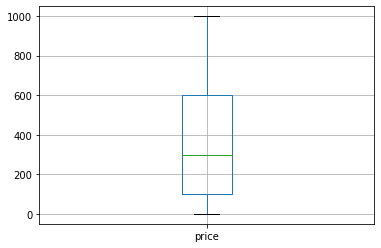

In [0]:
game_price_df_boxplot = game_price_df.filter(F.col('price')<=PRICE_Q3_THRESHOLD).toPandas().boxplot(column='price').plot()


##### Focus on prices > Q3 excluding outlier #####

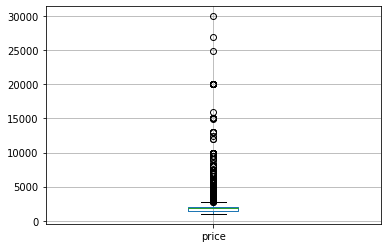

In [0]:
game_price_df_boxplot = game_price_df.filter((F.col('price')>PRICE_Q3_THRESHOLD) & (F.col('price')<99900))\
.toPandas().boxplot(column='price').plot()


### Games with discount ###


In [0]:

print('Percentage of games with a discount : ',format_2_decimals((game_price_df.filter(F.col('discount') > 0).count())*100/games_count))

Percentage of games with a discount :  4.54


##### Top 10 publishers in term of mean price (focusing on games with price >  Q3) #####

In [0]:
game_price_df.filter((F.col('price')>PRICE_Q3_THRESHOLD) & (F.col('price')<99900)).groupBy(F.col('publisher')).agg(F.count('id')\
   .alias('nb_games')\
  ,F.mean('price').alias('mean_price')\
  ,F.max('price').alias('max_price'))\
    .orderBy(F.desc('mean_price')).limit(10).show()

+--------------------+--------+----------+---------+
|           publisher|nb_games|mean_price|max_price|
+--------------------+--------+----------+---------+
|            Aartform|       1|   29990.0|    29990|
|              SideFX|       1|   26999.0|    26999|
|AssetFlipGames Wo...|       1|   19999.0|    19999|
|           StaplesVR|       1|   19999.0|    19999|
|          3Dflow SRL|       1|   19999.0|    19999|
|             Klip VR|       1|   19999.0|    19999|
|              H.G.G.|       1|   19999.0|    19999|
|          EFatullaev|       1|   19999.0|    19999|
|             rongyou|       1|   19999.0|    19999|
|             wandwad|       1|   19999.0|    19999|
+--------------------+--------+----------+---------+



##### Comparing to Top 10 publishers in term of mean price (focusing on games with price <= Q3) #####

In [0]:
game_price_df.filter(F.col('price')<=PRICE_Q3_THRESHOLD).groupBy(F.col('publisher')).agg(F.count('id').alias('nb_games')\
                                                   ,F.mean('price').alias('mean_price')\
                                                   ,F.max('price').alias('max_price')
                                                   ).orderBy(F.desc('mean_price')).limit(10).show()

+--------------------+--------+----------+---------+
|           publisher|nb_games|mean_price|max_price|
+--------------------+--------+----------+---------+
|        Selecta Play|       1|     999.0|      999|
| PunchButton Studios|       1|     999.0|      999|
|Axis Game Factory...|       1|     999.0|      999|
|        S H B studio|       1|     999.0|      999|
|             XIAOYAO|       1|     999.0|      999|
|   Groliver7 Studios|       1|     999.0|      999|
|    Carpe Fulgur LLC|       2|     999.0|      999|
|Navila Software J...|       1|     999.0|      999|
|         Amazu Media|       1|     999.0|      999|
|        Winteractive|       1|     999.0|      999|
+--------------------+--------+----------+---------+



##### Explode list of genres and compute statistics by genre #####

In [0]:
from pyspark.sql.functions import split, trim

games_genre_split_df = game_price_df.withColumn('genre_splited', F.expr("transform(split(genre,','),x -> trim(x))"))\
    .withColumn('genre_splited',F.explode('genre_splited')).drop('genre')\
    .select('id', 'price','genre_splited', 'average_income')

#### Top 10 genres in term of mean price (focusing on games with price > Q3) ####

In [0]:
games_genre_split_df.filter(F.col('price')>PRICE_Q3_THRESHOLD).groupBy('genre_splited').agg(F.count('id').alias('id_count')\
                                                            , F.max('price').alias('max_price')\
                                                            ,F.avg('price').alias('avg_price')
                                                            ).orderBy(F.desc('avg_price')).limit(10).show()

+--------------------+--------+---------+------------------+
|       genre_splited|id_count|max_price|         avg_price|
+--------------------+--------+---------+------------------+
|    Video Production|      80|    26999|          5458.975|
|Animation & Modeling|     117|    29990| 4836.461538461538|
|    Audio Production|      80|    14999|         4447.3625|
|          Accounting|       5|     8999|            4399.0|
|Design & Illustra...|     163|    26999|4348.9693251533745|
|       Photo Editing|      48|     9999| 4221.479166666667|
|      Web Publishing|      45|     9999| 4100.133333333333|
|    Game Development|      78|    26999|4020.8076923076924|
|           Education|     103|    19999| 3917.368932038835|
|   Software Training|      82|    12999| 3522.451219512195|
+--------------------+--------+---------+------------------+



##### Comparing to Top 10 genres in term of mean price (focusing on games with price <= Q3) #####

In [0]:
games_genre_split_df.filter(F.col('price')<=PRICE_Q3_THRESHOLD).groupBy('genre_splited').agg(F.count('id').alias('id_count')\
                                                            , F.max('price').alias('max_price')\
                                                            ,F.avg('price').alias('avg_price')
                                                            ).orderBy(F.desc('avg_price')).limit(10).show()

+--------------+--------+---------+------------------+
| genre_splited|id_count|max_price|         avg_price|
+--------------+--------+---------+------------------+
|Sexual Content|      44|      999|449.22727272727275|
|     Adventure|   16243|      999| 431.7616819553038|
|    Simulation|    7778|      999| 431.0257135510414|
|  Early Access|    4206|      999|426.87565382786494|
|      Strategy|    8092|      999| 425.9206623826001|
|        Nudity|      37|      999|424.94594594594594|
|           RPG|    6732|      999| 410.9024064171123|
|        Sports|    1966|      999| 408.6144455747711|
|        Action|   18351|      999| 405.6183314260803|
|        Racing|    1643|      999|399.67802799756544|
+--------------+--------+---------+------------------+



### What are the most represented languages ? ###

In [0]:
games_count_by_language_dtf = steam_game_dtf_level0.select('id','languages')\
.withColumn('languages_splited', F.expr("transform(split(languages,','),x -> trim(x))"))\
    .withColumn('language',F.explode('languages_splited'))\
        .groupBy('language').agg(F.count('id').alias('id_count'))\
    .withColumn('percentage', F.round(((100*F.col('id_count'))/games_count),2))\
        .orderBy(F.desc('percentage')).limit(10)
display(games_count_by_language_dtf)

language,id_count,percentage
English,54748,98.98
German,13925,25.18
French,13323,24.09
Russian,12868,23.27
Simplified Chinese,12739,23.03
Spanish - Spain,12153,21.97
Japanese,10330,18.68
Italian,9240,16.71
Portuguese - Brazil,6719,12.15
Korean,6580,11.9


Databricks visualization. Run in Databricks to view.

### Are there many games prohibited for children under 16/18 ? ###

In [0]:
games_with_age_limit_count = steam_game_dtf_level0.select('id','required_age').withColumn('required_age',F.col('required_age').cast(IntegerType()))\
    .filter(F.col('required_age').between(16,18)).count()
print('Percentage of games prohibited for children under 16/18 years : ',format_2_decimals(games_with_age_limit_count*100/games_count), '%')

Percentage of games prohibited for children under 16/18 years :  0.53 %


## Genres analysis ##

### What are the most represented genres ? ###

In [0]:
from pyspark.sql.functions import split, trim

games_genre_split_df = steam_game_dtf_level0.withColumn('genre_splited', F.expr("transform(split(genre,','),x -> trim(x))"))\
    .withColumn('genre_splited',F.explode('genre_splited')).drop(F.col('genre'))
games_genre_split_df.groupBy('genre_splited').agg(F.count('id').alias('id_count')\
                                                            ).orderBy(F.desc('id_count')).limit(10).show()

+-------------+--------+
|genre_splited|id_count|
+-------------+--------+
|        Indie|   39547|
|       Action|   23657|
|       Casual|   21999|
|    Adventure|   21363|
|     Strategy|   10859|
|   Simulation|   10800|
|          RPG|    9511|
| Early Access|    6130|
| Free to Play|    3389|
|       Sports|    2656|
+-------------+--------+



### Are there any genres that have a better positive/negative review ratio? ###

#### Top 10 genres in term of average positive rate ####

In [0]:
games_genre_split_df.groupBy('genre_splited').agg(F.round(F.mean('positive_rate'),2).alias('mean_positive_rate')\
                            , F.round(F.stddev('positive_rate'),2).alias('sdtdev_positive_rate')\
                                                            ).orderBy(F.desc('mean_positive_rate')).limit(10).show()

+--------------------+------------------+--------------------+
|       genre_splited|mean_positive_rate|sdtdev_positive_rate|
+--------------------+------------------+--------------------+
|           Adventure|              0.74|                0.24|
|    Game Development|              0.74|                0.26|
|              Casual|              0.74|                0.25|
|               Indie|              0.74|                0.24|
|              Action|              0.73|                0.25|
|                 RPG|              0.73|                0.23|
|      Web Publishing|              0.72|                0.23|
|          Accounting|              0.72|                0.25|
|Design & Illustra...|              0.72|                0.24|
|            Strategy|              0.72|                0.24|
+--------------------+------------------+--------------------+



### Do some publishers have favorite genres ? ###

#### Plot number of distinct genres covered by supplier ####

nb_genres :  the number of distinct genres by publisher

nb_publisher : number of (distinct) publishers with (exactly) nb_genres

In [0]:
nb_publishers_by_genres_count = games_genre_split_df.groupBy('publisher').agg(F.count_distinct('genre_splited').alias("nb_genres"))\
    .groupBy('nb_genres').agg(F.count('publisher').alias('nb_publishers'))\
    .orderBy(F.asc('nb_genres'))

**As we can see below** 
- 90% of publishers have at most 5 genres (1 or 2 or 3 or 4 or 5)
- publishers with games covering a single genre represent 9.7%

In [0]:
from pyspark.sql import Window

total_publishers_count = nb_publishers_by_genres_count.agg(F.sum('nb_publishers')).collect()[0][0]
print('number of publishers : ',total_publishers_count)
nb_publishers_by_genres_count.withColumn('cumulated_perc',\
                                           F.round((100*F.sum('nb_publishers').over(Window.orderBy('nb_genres'))/total_publishers_count),2)).limit(20).show()


number of publishers :  29914
+---------+-------------+--------------+
|nb_genres|nb_publishers|cumulated_perc|
+---------+-------------+--------------+
|        1|         2899|          9.69|
|        2|         6759|         32.29|
|        3|         8593|         61.01|
|        4|         5563|         79.61|
|        5|         3118|         90.03|
|        6|         1545|          95.2|
|        7|          752|         97.71|
|        8|          376|         98.97|
|        9|          150|         99.47|
|       10|           83|         99.75|
|       11|           40|         99.88|
|       12|           22|         99.95|
|       13|            4|         99.97|
|       14|            3|         99.98|
|       15|            2|         99.98|
|       16|            3|         99.99|
|       17|            1|         100.0|
|       19|            1|         100.0|
+---------+-------------+--------------+



#### Compute games breakdown by publisher and genre  ####

In [0]:
from pyspark.sql import Window

publisher_partition = Window.partitionBy('publisher')

favourites_genres_by_publisher_df = games_genre_split_df.groupBy('publisher', 'genre_splited').agg(F.count('id').alias("nb_games"))\
    .withColumn('percentage', 100*F.round(F.col('nb_games')/F.sum('nb_games').over(publisher_partition),2))\
        .withColumn('nb_genres', F.count(F.col('nb_games')).over(publisher_partition))

#### Focus on publishers with several genres ####

In [0]:
#favourites_genres_by_publisher_df_top_10=

window_pub_perc_desc = Window.partitionBy('publisher').orderBy(F.desc('percentage'))
favourites_genres_by_publisher_df.filter(F.col('nb_genres') > 1)\
    .withColumn('rank', F.row_number().over(window_pub_perc_desc))\
    .withColumn('publisher_first_genre',F.concat(F.col('publisher'),F.lit(' ('),F.col('genre_splited'),F.lit(')')))\
    .filter(F.col('rank') == 1).drop('rank')\
.orderBy(F.desc('percentage')).limit(10).show()

#

+--------------------+----------------+--------+----------+---------+---------------------+
|           publisher|   genre_splited|nb_games|percentage|nb_genres|publisher_first_genre|
+--------------------+----------------+--------+----------+---------+---------------------+
|        HexWar Games|        Strategy|      42|      98.0|        2| HexWar Games (Str...|
|     CITY CONNECTION|          Action|      18|      95.0|        2| CITY CONNECTION (...|
|          grin robot|           Indie|      10|      91.0|        2|   grin robot (Indie)|
|       Erbe Software|       Adventure|       8|      89.0|        2| Erbe Software (Ad...|
|      BrainGoodGames|        Strategy|       7|      88.0|        2| BrainGoodGames (S...|
|            Cakewalk|Audio Production|       7|      88.0|        2| Cakewalk (Audio P...|
|     HeR Interactive|       Adventure|      29|      88.0|        5| HeR Interactive (...|
|            OFF1C1AL|       Adventure|       6|      86.0|        2| OFF1C1AL (

##### Focus on publishers with 2 genres #####

In [0]:
favourites_genres_by_publisher_df.filter(F.col('nb_genres') ==2).orderBy(F.desc('percentage')).limit(10).show()

+--------------------+----------------+--------+----------+---------+
|           publisher|   genre_splited|nb_games|percentage|nb_genres|
+--------------------+----------------+--------+----------+---------+
|        HexWar Games|        Strategy|      42|      98.0|        2|
|     CITY CONNECTION|          Action|      18|      95.0|        2|
|          grin robot|           Indie|      10|      91.0|        2|
|       Erbe Software|       Adventure|       8|      89.0|        2|
|      BrainGoodGames|        Strategy|       7|      88.0|        2|
|            Cakewalk|Audio Production|       7|      88.0|        2|
|            OFF1C1AL|       Adventure|       6|      86.0|        2|
|Trend Redaktions-...|      Simulation|       6|      86.0|        2|
|            GC Games|          Casual|       5|      83.0|        2|
|         Bliss Brain|      Simulation|       5|      83.0|        2|
+--------------------+----------------+--------+----------+---------+



##### Focus on publishers with 3 genres #####

In [0]:
favourites_genres_by_publisher_df.filter(F.col('nb_genres') ==3).orderBy(F.desc('percentage')).limit(10).show()

+--------------------+-------------+--------+----------+---------+
|           publisher|genre_splited|nb_games|percentage|nb_genres|
+--------------------+-------------+--------+----------+---------+
|     Notus Games Ltd|       Casual|      11|      85.0|        3|
| Ziggurat, 612 Games|       Action|      11|      79.0|        3|
|GSC World Publishing|     Strategy|       7|      78.0|        3|
|              Fewjix|        Indie|       6|      75.0|        3|
|    ShortStackStudio|       Casual|       6|      75.0|        3|
|        Sigyaad Team|       Casual|       9|      75.0|        3|
|       Team Spikkeee|       Casual|       6|      75.0|        3|
|         Remix Games|       Casual|       9|      75.0|        3|
|Mens Sana Interac...|       Casual|      20|      74.0|        3|
|PopCap Games, Inc...|       Casual|      11|      73.0|        3|
+--------------------+-------------+--------+----------+---------+



In [0]:
from pyspark.sql import Window

favourites_genres_by_publisher_df = games_genre_split_df.rollup('publisher', 'genre_splited').agg(F.count('id').alias("nb_games"))\
    .withColumn('percentage', F.col('nb_games')/F.count('nb_games').over(Window.partitionBy('publisher')))

favourites_genres_by_publisher_df.filter(F.col('publisher')=='Big Fish Games').orderBy(F.desc('percentage')).limit(20).show()

+--------------+-------------+--------+----------+
|     publisher|genre_splited|nb_games|percentage|
+--------------+-------------+--------+----------+
|Big Fish Games|         null|     833|   104.125|
|Big Fish Games|       Casual|     418|     52.25|
|Big Fish Games|    Adventure|     392|      49.0|
|Big Fish Games|        Indie|       7|     0.875|
|Big Fish Games|   Simulation|       7|     0.875|
|Big Fish Games|     Strategy|       6|      0.75|
|Big Fish Games|       Sports|       2|      0.25|
|Big Fish Games|       Action|       1|     0.125|
+--------------+-------------+--------+----------+



In [0]:
games_genre_split_df.filter(F.col('publisher')=='Big Fish Games').count()

Out[55]: 833

### What are the most lucrative genres ? ###

We consider the average income by genre. average_income column is defined upstream

In [0]:
#most_lucrative_genres = 
games_genre_split_df.groupBy('genre_splited').agg(F.mean(F.col('average_income')).cast(DecimalType(20,2)).alias('average_income')\
              , F.round(F.mean(F.col('avg_owners')),2).alias('avg_owners')\
              ).orderBy(F.desc('average_income')).limit(10).show()
#display(most_lucrative_genres)

+--------------------+--------------+----------+
|       genre_splited|average_income|avg_owners|
+--------------------+--------------+----------+
|                 RPG|   35218514.47| 182642.73|
|            Strategy|   31234072.48| 149803.39|
|          Simulation|   29725752.83| 121870.83|
|      Web Publishing|   29484734.29|  60168.54|
|              Action|   28092124.84| 199940.61|
|              Racing|   27245144.86|   87456.8|
|    Game Development|   26582515.72|  33050.31|
|           Adventure|   26080254.93| 122863.83|
|   Software Training|   23725617.28|  36234.57|
|Animation & Modeling|   23383821.49| 163354.23|
+--------------------+--------------+----------+



In [0]:
games_genre_split_df.filter(F.col('id')==outlier_id).select('id', 'name', 'publisher', 'genre_splited', 'price').limit(10).show()

+-------+--------------------+----------+-------------+-----+
|     id|                name| publisher|genre_splited|price|
+-------+--------------------+----------+-------------+-----+
|1200520|Ascent Free-Roami...|Fury Games|       Action|99900|
+-------+--------------------+----------+-------------+-----+



## Platform analysis ##

### Are most games available on Windows/Mac/Linux instead ? ###

Join steam_game_dtf_level0 DataFrame with data's platforms fields (on id) to receive steam_game_dtf_level0 pre processing

In [0]:
platform_df = steam_game_dtf_level0.join(((steam_game_dtf.withColumn('platform_windows', F.col('data.platforms').getField('windows'))\
    .withColumn('platform_linux', F.col('data.platforms').getField('linux'))\
    .withColumn('platform_mac', F.col('data.platforms').getField('mac'))\
    .select('id','platform_windows','platform_linux','platform_mac')).alias('platform_df')), on='id', how="inner")
    #Check
platform_df.select('id', 'name', 'price', 'publisher', 'platform_windows','platform_linux','platform_mac').limit(2).show()

+-------+--------------+-----+--------------------+----------------+--------------+------------+
|     id|          name|price|           publisher|platform_windows|platform_linux|platform_mac|
+-------+--------------+-----+--------------------+----------------+--------------+------------+
|     10|Counter-Strike|  999|               Valve|            true|          true|        true|
|1000000|     ASCENXION|  999|PsychoFlux Entert...|            true|         false|       false|
+-------+--------------+-----+--------------------+----------------+--------------+------------+



As we can see below 100% of the games are available on windows, but 23% on Mac and 15% on Linux

In [0]:
row_count = platform_df.agg(F.count('id')).collect()[0][0]
platform_df.select(\
    F.round((F.sum(F.when(F.col('platform_windows'),1).otherwise(0))/row_count),2).alias('perc_windows_platform')\
    ,F.round((F.sum(F.when(F.col('platform_linux'),1).otherwise(0))/row_count),2).alias('perc_linux_platform')\
    ,F.round((F.sum(F.when(F.col('platform_mac'),1).otherwise(0))/row_count),2).alias('perc_mac_platform')\
).show()

+---------------------+-------------------+-----------------+
|perc_windows_platform|perc_linux_platform|perc_mac_platform|
+---------------------+-------------------+-----------------+
|                  1.0|               0.15|             0.23|
+---------------------+-------------------+-----------------+



### Do certain genres tend to be preferentially available on certain platforms ? ###

In [0]:
games_plaform_genre_split_df = platform_df.filter(~is_empty_string(F.col('genre'))).withColumn('genre_splited', F.expr("transform(split(genre,','),x -> trim(x))"))\
    .withColumn('genre_splited',F.explode('genre_splited')).drop(F.col('genre'))


In [0]:
partion_by_genre_w = Window.partitionBy('genre_splited')

platform_perc_columns = ['perc_windows_platform','perc_linux_platform','perc_mac_platform']

first_platform_by_genre_df = games_plaform_genre_split_df.groupBy('genre_splited').agg( (F.sum(F.when(F.col('platform_windows'),1).otherwise(0))).alias('sum_windows_platform')\
    ,(F.sum(F.when(F.col('platform_linux'),1).otherwise(0))).alias('sum_linux_platform')\
    ,(F.sum(F.when(F.col('platform_mac'),1).otherwise(0))).alias('sum_mac_platform')\
    ).withColumn('sum_platforms', F.col('sum_windows_platform') + F.col('sum_linux_platform') + F.col('sum_mac_platform'))\
        .withColumn(platform_perc_columns[0],F.round(100*F.col('sum_windows_platform')/F.col('sum_platforms'),2))\
        .withColumn(platform_perc_columns[1],F.round(100*F.col('sum_linux_platform')/F.col('sum_platforms'),2))\
        .withColumn(platform_perc_columns[2],F.round(100*F.col('sum_mac_platform')/F.col('sum_platforms'),2))\
        .drop(F.col('sum_windows_platform'), F.col('sum_linux_platform'), F.col('sum_mac_platform'), F.col('sum_platforms'))\
        .withColumn("first_platform",\
            F.when(F.col("perc_windows_platform") == F.greatest(*platform_perc_columns), F.lit("Windows"))
         .when(F.col("perc_linux_platform") == F.greatest(*platform_perc_columns), F.lit("Linux"))
         .otherwise(F.lit("Mac")))


#### As we can see below, first platform is always windows ####

In [0]:
first_platform_by_genre_df.groupBy(F.col('first_platform')).agg(F.count('genre_splited'))\
    .select('*').show()

+--------------+--------------------+
|first_platform|count(genre_splited)|
+--------------+--------------------+
|       Windows|                  28|
+--------------+--------------------+



#### The most represented genres on Linux platform ####

In [0]:
top_10_linux_platform_by_genre_df = first_platform_by_genre_df\
    .select("genre_splited", "perc_windows_platform", "perc_linux_platform", "perc_mac_platform", "first_platform")\
        .orderBy(F.desc(F.col('perc_linux_platform'))).limit(5)
display(top_10_linux_platform_by_genre_df)

genre_splited,perc_windows_platform,perc_linux_platform,perc_mac_platform,first_platform
Game Development,64.63,14.23,21.14,Windows
Indie,70.16,12.3,17.53,Windows
Strategy,69.31,11.6,19.09,Windows
RPG,71.71,11.42,16.86,Windows
Nudity,72.58,11.29,16.13,Windows


Databricks visualization. Run in Databricks to view.

The most represented genres on Mac platform

In [0]:
top_10_mac_platform_by_genre_df = first_platform_by_genre_df\
    .select("genre_splited", "perc_windows_platform", "perc_linux_platform", "perc_mac_platform", "first_platform")\
        .orderBy(F.desc(F.col('perc_mac_platform'))).limit(5)
display(top_10_mac_platform_by_genre_df)

genre_splited,perc_windows_platform,perc_linux_platform,perc_mac_platform,first_platform
Game Development,64.63,14.23,21.14,Windows
Accounting,80.0,0.0,20.0,Windows
Strategy,69.31,11.6,19.09,Windows
Free to Play,72.03,10.04,17.93,Windows
Design & Illustration,72.4,9.68,17.92,Windows


Databricks visualization. Run in Databricks to view.

In [0]:
result = (
    first_platform_by_genre_df
    .groupBy("first_platform")
    .agg(
        F.collect_list("genre_splited").alias("genres"),
        F.size(F.collect_list("genre_splited")).alias("nb_genres")
    )
)

result.show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 first_platform | Windows                                                                                                                                                                                                                                                                                                                                                               
 genres         | [Education, Massively Multiplayer, Sexual Content, Adventure, Sports, Accounting, Audio Production, Video Production, Animation & Modeling, Racing, Gore, Design & Illustration, Software Training, Web Publishing, Photo Editing, U